In [171]:
from google.cloud import language
import facebook
import requests
import random
import pandas as pd
import seaborn as sns
from IPython.core.display import display, HTML
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from itertools import chain
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100





gcl = language.Client()
with open("fbtoken", 'r') as tokfile:
    FBTOKEN = tokfile.read()
fb = facebook.GraphAPI(FBTOKEN, version='2.5')

# Sentiment Analysis

Of late there's been a lot of talk....


## Data Acquisition: Facebook API
### Posts:
We'll start by grabbing the last ~100 posts from Patagonia and REI. 

In [172]:
company_ids = {
    'patagonia':'97830335456',
    'rei':'9062006483', 
    'outdoorresearch': '103571854707'
}

In [173]:
company_posts = dict.fromkeys(company_ids.keys(), [])
for name in company_ids:
    posts = fb.get_connections(company_ids[name], 'posts')
    count = 0
    while count < 10:
        try:

            company_posts[name] = company_posts[name] + posts['data']
            # Attempt to make a request to the next page of data, if it exists.
            posts = requests.get(posts['paging']['next']).json()
            count += 1
        except KeyError as e:
            print(e)
            # When there are no more pages (['paging']['next']), break from the
            # loop and end the script.
            break

In [174]:
all_posts = None
for company in company_posts:
    print(company)
    tmp = pd.DataFrame(company_posts[company]).set_index('id')
    tmp['company'] = company
    if all_posts is None:
        all_posts = tmp
    else:
        all_posts = pd.concat([all_posts, tmp])
    
print("Total posts:", len(all_posts))
all_posts.sample(15)


rei
patagonia
outdoorresearch
Total posts: 750


,created_time,message,story,company
id,,,,
9062006483_10153780132626484,2015-12-19T01:00:19+0000,Love art? Love National Parks? Our friends at ...,NaN,rei
103571854707_10155385062899708,2017-05-13T15:30:00+0000,Keep the kiddos stoked!,NaN,outdoorresearch
97830335456_10158212802835457,2017-01-20T17:37:35+0000,"Patagonia’s #OathOfAction is to volunteer 14,0...",NaN,patagonia
103571854707_10155471453869708,2017-06-02T22:42:24+0000,Pioneers were the original gangsters of #vanli...,Outdoor Research added 2 new photos.,outdoorresearch
97830335456_10158972665235457,2017-06-12T17:19:24+0000,Climbing in public lands with no other plans. ...,NaN,patagonia
103571854707_10155132819439708,2017-02-15T16:30:01+0000,What makes this pro skier and OR Ambassador tick?,NaN,outdoorresearch
97830335456_10158413585890457,2017-02-28T21:54:20+0000,"Brittany Griffith has a V8 engine, cold condit...",NaN,patagonia
97830335456_10158987470340457,2017-06-14T22:30:05+0000,"""Despite the various crusts that have formed o...",NaN,patagonia
103571854707_10155176300624708,2017-03-03T19:30:00+0000,Beat the late winter doldrums with recommendat...,NaN,outdoorresearch



#### Post Examples
A random post from REI:

In [175]:
def show_post(longid):
    FB_EMBED = '<iframe src="https://www.facebook.com/plugins/post.php?href=https%3A%2F%2Fwww.facebook.com%2F{}%2Fposts%2F{}&width=500&show_text=true&height=591" width="500" height="591" style="border:none;overflow:hidden" scrolling="no" frameborder="0" allowTransparency="true"></iframe>'
    pageid, postid = longid.split("_")
    display(HTML(FB_EMBED.format(pageid, postid)))

post = random.sample(company_posts['rei'], 1)[0]
print(post)
show_post(post['id'])


{'id': '9062006483_10155386435806484', 'created_time': '2017-06-08T17:13:11+0000', 'message': 'Gassed up and ready to go. Weekend Project: Show off your adventure-mobile in the comments below. #LetsCamp'}


And Patagonia: 

In [176]:
post = random.sample(company_posts['patagonia'], 1)[0]
print(post)
show_post(post['id'])

{'id': '97830335456_10158403951250457', 'created_time': '2017-02-26T19:14:41+0000', 'message': 'Your passwords are safe around these hackers. Photo: Bernd Zeugswetter'}


---
### Comment Acquisition
*So*, we've got **{{len(company_posts['rei'])}} posts** for REI and **{{len(company_posts['patagonia'])}} posts** for Patagonia to look at. Let's take a random sample of 100 from each and see what the comment statistics look like.

First, we download the comments for those 100 each. 

In [177]:
comments = pd.DataFrame()
SAMPLE_SIZE = 100
for company, posts in all_posts.groupby("company"):
    print(company)
    samp = posts.sample(n=SAMPLE_SIZE)
    print(len(samp))
    for int,post in samp.iterrows():
        thisPostComments = pd.DataFrame(fb.request(post.name+'/comments', args={'limit':5000})['data'])
        thisPostComments['company'] = company
        thisPostComments['post_id'] = post.name
        comments = pd.concat([comments, thisPostComments])
        
        

outdoorresearch
100
patagonia
100
rei
100


#### Comment Examples:
Let's take a look at a couple random comments (here, the comment is in **bold** above the post it's on):

In [178]:
for i in range(5):
    randComment = comments.sample(n=1)
    display(HTML("<b>"+randComment['message'].values[0]+"</b> <i> "+randComment['company'].values[0]+" </i>"))
    show_post(randComment['post_id'].values[0])


Excellent, things seem to be working. Let's do a little more visualization.

## Comment Visualization.
Here we'll just do a word count plot to try out this analysis. 

We must remove stop words!

outdoorresearch
patagonia
rei


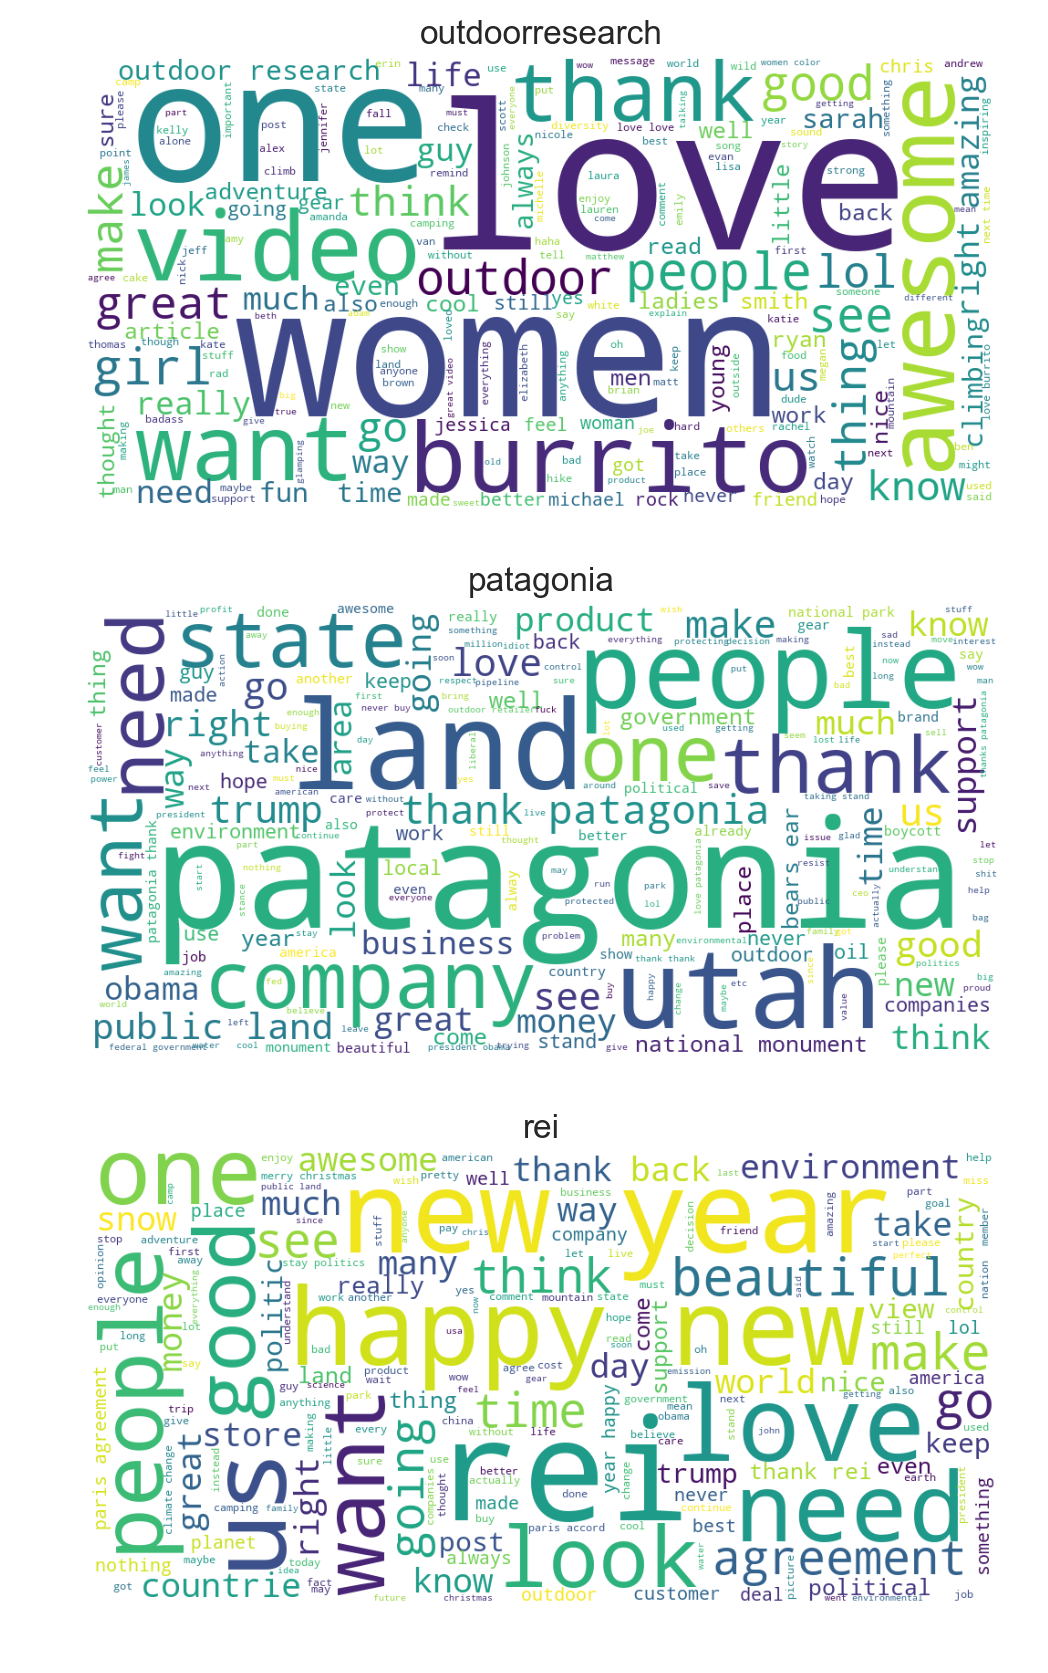

In [179]:
STOP_WORDS = stopwords.words('english')
fig, ax = plt.subplots(len(company_ids))
companyIdx = 0
for company, messages in comments.groupby('company')['message']:
    print(company)
    companyRow = ax[companyIdx]
    companyIdx += 1
    counter = Counter()
    allwords = list(chain.from_iterable(messages.str.lower().str.split()))
    
    filtered_words = [word for word in allwords if word not in STOP_WORDS]

    names, counts = zip(*Counter(filtered_words).most_common(10))
    
    wc = WordCloud(background_color='white', scale=2.5)
    wcloud = wc.generate(" ".join(filtered_words))
    companyRow.imshow(wcloud, interpolation='bilinear')
    companyRow.set_title(company)
    companyRow.axis('off')
    #sns.barplot(names, counts)
    #plt.title(company)
    #plt.show()
    
    


### Comments containing Certain Words

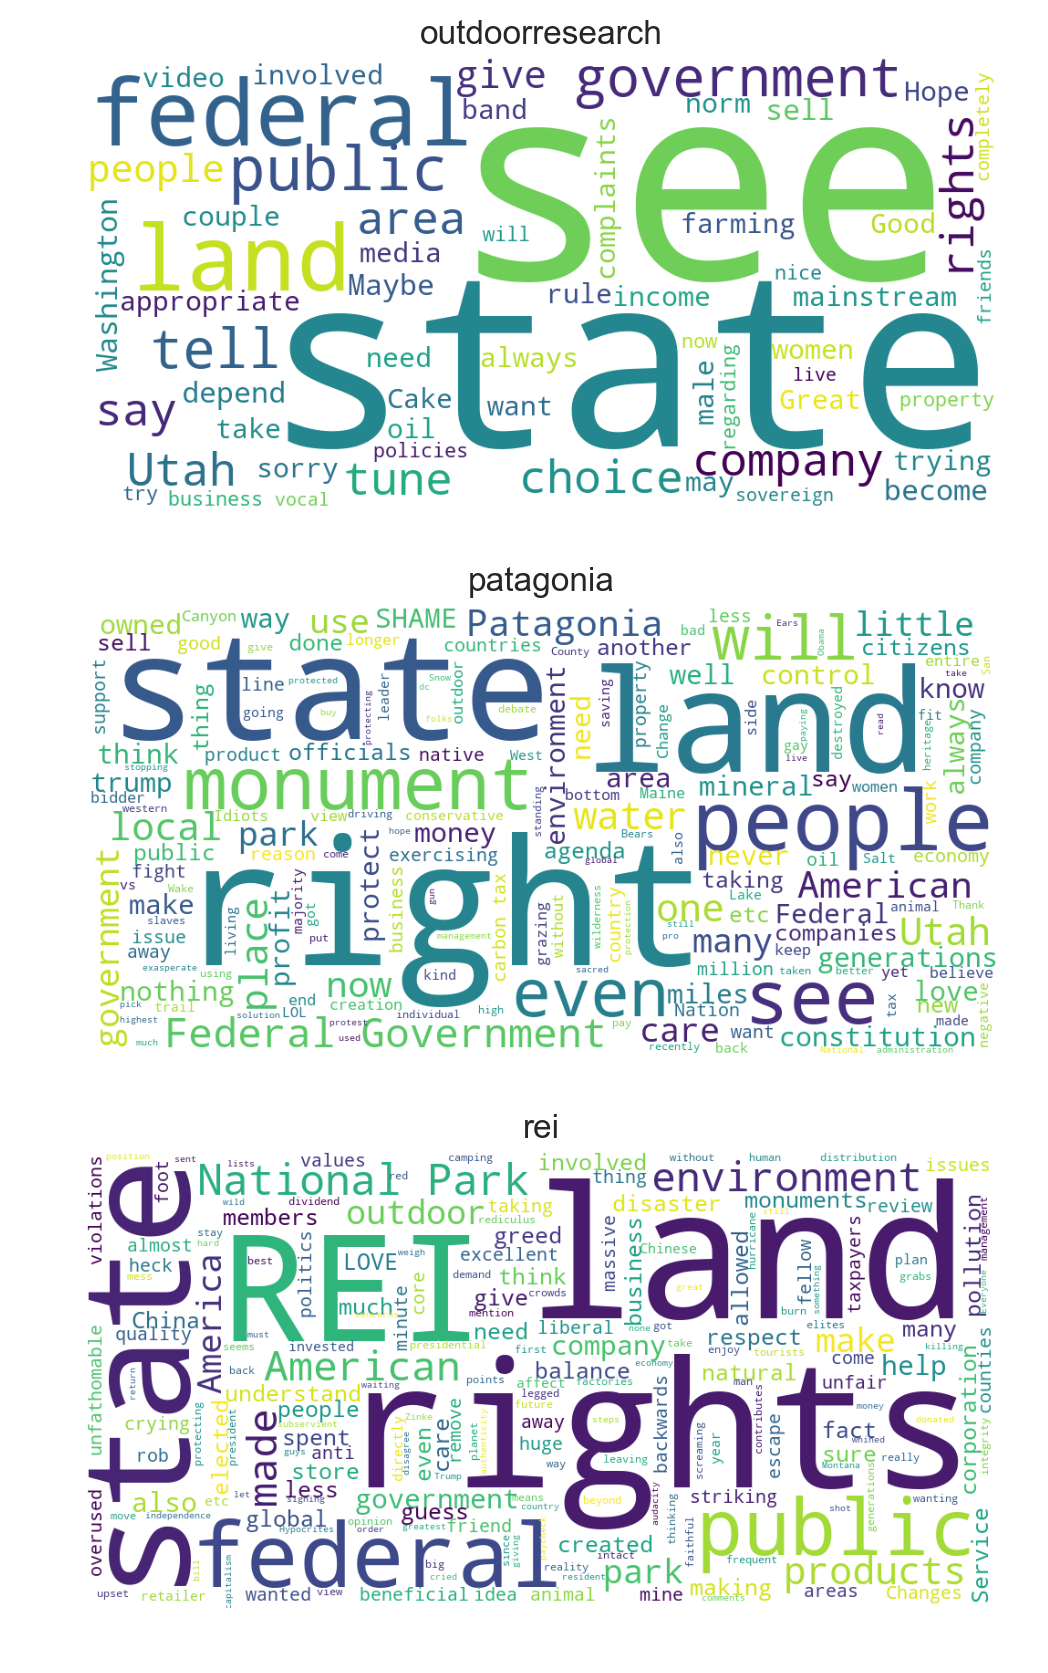

In [180]:

fig, ax = plt.subplots(len(company_ids))
companyIdx = 0
for company, messages in comments.groupby('company')['message']:
    filtered_words = messages[messages.str.contains('rights')]
    companyRow = ax[companyIdx]
    companyIdx += 1
    wc = WordCloud(background_color='white', scale=2.5)
    wcloud = wc.generate(" ".join(filtered_words))
    companyRow.imshow(wcloud, interpolation='bilinear')
    companyRow.set_title(company)
    companyRow.axis('off')



    
